# Applying InfEmbed on Resnet18 trained on Imagenet
This notebook shows how to apply InfEmbed on a Resnet18 model trained on the Imagenet dataset.  As a reminder, applying InfEmbed consists of 2 steps:
1. **Compute embeddings**: Compute embeddings for examples in the evaluation data.  For this step, we can select from several Embedders, i.e. implementations of `EmbedderBase`. 

    <em>We recommend to use `FastKFACEmbedder`, the most scalable implementation</em>
2. **Cluster embeddings**: Cluster the embeddings using a standard clustering method which clusters all the provided data (i.e. K-means), or a rule-based clustering method which returns the largest clusters satisfying a user-specified rule.  This gives clusters whose errors are "wrong for the same reasons".

    <em>We recommend to use both standard and rule-based clustering to get a global and local view of the errors.</em>

#### Notebook outline
In this notebook, we will:
- download the Imagenet data
- define the `DataLoader`s and `Dataset`s based on Imagenet
- define the Resnet18 model
- define the `FastKFACEmbedder` instance used to compute embeddings
- compute embeddings using the instance
- compute metadata useful for displaying examples (i.e. get predictions of Resnet18)
- cluster the embeddings to get clusters using standard clustering and view them
- cluster the embeddings to get clusters using rule-based clustering and view them

If the Imagenet data is already downloaded, on a GPU the notebook should run end-to-end in ~5 minutes.

#### Pre-requisites
- make sure `infembed` is installed, i.e. via `pip`, or by making sure the folder containing `infembed` is added to `PYTHONPATH`
- download the Imagenet data.  this can be done via a cell in this notebook (which calls a script `./get_imagenet.sh`), or directly running that script in the terminal


## Preparatory code

In [3]:
import sys
sys.path.insert(0, '/home/ubuntu/Documents/infembed')

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.


In [ ]:
from datetime import datetime
import torch
torch.multiprocessing.set_start_method('spawn') # needed to enable dataloaders with multiple workers

figure out device to compute embeddings

In [102]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('device:', DEVICE)

device: cuda:0


## Download imagenet data
the cell below only needs to be run once

In [ ]:
DOWNLOAD_DATA = True

if DOWNLOAD_DATA:
    ! ./get_imagenet.sh

## Define the `DataLoader`s and `Dataset`s based on Imagenet
We will define the following:
- `eval_dataloader`: `DataLoader` for evaluation data, i.e. the data in which we will identify errors.  It is used to compute embeddings for the evaluation data.  We will create a dataloader based on the entire validation split of Imagenet (50000 examples).
- `eval_dataset`: `Dataset` for evaluation data.  It is used to retrieve individual examples for displaying.  As above, this will be the entire validation split of Imagenet.
- `train_dataloader`: `DataLoader` for "training" data, i.e. the data that `FastKFACEmbedder` uses to know how to compute the embeddings.  Ideally, we would use the Imagenet training data, but it is too large to download.  Therefore we will again use the validation split of Imagenet as the "training" data.  Furthermore, in practice, the "training" data only needs to be several thousand examples (it is used to estimate the Hessian).  Therefore, `train_dataloader` will be created from a randomly chosen subset of 5000 examples from the Imagenet validation data.

In [61]:
import torchvision
from helpers import ImagenetCollateFn
from torch.utils.data import DataLoader, Subset

DATASET_PATH = "imagenet_data"
eval_dataset = torchvision.datasets.ImageNet(DATASET_PATH, split="val")

collate_fn = ImagenetCollateFn(DEVICE)
BATCH_SIZE = 32
NUM_WORKERS = 10

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

_train_data = torchvision.datasets.ImageNet(DATASET_PATH, split="val")
NUM_TRAIN = 5000
train_data = Subset(_train_data, torch.randperm(len(_train_data))[:NUM_TRAIN])
train_dataloader = DataLoader(
    train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

## Define the Resnet18 model

In [6]:
from torchvision.models import ResNet18_Weights, resnet18
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device=DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define the `FastKFACEmbedder` instance used to compute embeddings
The main arguments to construct it are:
- `model`: the model whose predictions for which you want to find errors
- `layers`: `FastKFACEmbedder` (as well as other Embedders) leverage gradients to compute embeddings.  This is a list of the names of layers whose gradients to consider.  Ideally, we would use all layers, but in practice, we find that for classifiers, using the last-layer only already gives meaningful results.  Feel free to use additional layers by uncommenting out their names.
- `loss_fn`: the loss function used in training.  For classifiers, this will typically be `nn.CrossEntropyLoss(reduction='sum')`.  Note that this loss function cannot act like a `reduction='none'` loss function, i.e. it cannot return a separate loss for each example in a batch.  Instead, it should return a single loss for the entire batch, as does the loss function used here.
- `projection_dim`: The dimension of the embedding.  We find that `projection_dim=100` works well in practice.
- `projection_on_cpu`: `FastKFACEmbedder` learns a projection that transforms gradients to embeddings.  This argument determines whether to save the projection on CPU.  We recommend to set this to True, unless you have lots of GPU memory.
- `show_progress`: whether to show the progress of the computations in `fit` (learn how to compute the embeddings) and `predict` (actually compute the embeddings).
- `per_layer_blocks`: `FastKFACEmbedder` estimates the Hessian for each layer in `layers`.  To improve scalability (in terms of computation and memory), we can find a block diagonal approximation to the Hessian.  This argument determines the number of blocks in that approximation.  We recommend to leave this at 1, and only increase to ~5 if the computation is slow or running out of memory.

In [7]:
from embedder._core.fast_kfac_embedder import FastKFACEmbedder
import torch.nn as nn

embedder = FastKFACEmbedder(
    model=model,
    layers=[
        "fc",
        # "layer4.0.conv1",
        # "layer4.0.conv2",
        # "layer4.0.downsample.0",
        # "layer4.1.conv1",
        # "layer4.1.conv2",
    ],
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    projection_dim=100,
    projection_on_cpu=True,
    show_progress=True,
    per_layer_blocks=1,
)

/home/ubuntu/Documents/infembed/infembed/embedder/_utils/common.py:160: UserWarning: Setting required grads for layer: fc, name: weight
  warnings.warn(
/home/ubuntu/Documents/infembed/infembed/embedder/_utils/common.py:160: UserWarning: Setting required grads for layer: fc, name: bias
  warnings.warn(


## Compute embeddings using the instance

`FastKFACEmbedder` (as well as the other Embedders) mimics the Sklearn API.  To compute embeddings, we first call `fit` to learn how to compute the embeddings, and then `predict` to actually compute the embeddings.

So first, we call `fit`, which in more detail, estimates certain training data statistics, and then does eigendecompositions using them to form the Hessian approximation used to compute embeddings.  With GPU, this should take less than 2 minutes.

In [8]:
start_time = datetime.now()
embedder.fit(train_dataloader)
print(
    f"fit the embedder in {(datetime.now() - start_time).total_seconds() / 60.0} minutes"
)

INFO:root:compute training data statistics


processing `hessian_dataset` batch:   0%|          | 0/157 [00:00<?, ?it/s]/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
processing `hessian_dataset` batch: 100%|██████████| 157/157 [00:35<00:00,  4.45it/s]
INFO:root:compute factors, first pass to get eigenvalue threshold
INFO:root:compute factors
INFO:root:compute factors for layer Linear(in_features=512, out_features=1000, bias=True)
INFO:root:compute factors, second pass to get eigenvalue threshold
INFO:root:compute factors
INFO:root:compute factors for layer Linear(in_features=512, out_features=1000, bias=True)


fit the embedder in 1.3988696166666665 minutes


Then we call `predict` to actually compute the embeddings.  With GPU, this should take ~2 minutes for the Imagenet validation data.

In [9]:
start_time = datetime.now()
embeddings = embedder.predict(eval_dataloader)
print(
    f"computed the embeddings in {(datetime.now() - start_time).total_seconds() / 60.0} minutes"
)

Using FastKFACEmbedder to compute embeddings. Processing batch:   0%|          | 0/1563 [00:23<?, ?it/s]

INFO:root:compute embeddings
[W CudaIPCTypes.cpp:15] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]


computed the embeddings in 2.130640166666667 minutes


## Compute metadata useful for displaying examples
This will be useful for displaying examples / clusters, and also used in the rule-based clustering.

First, get model predictions and labels to place into a metadata dataframe.

In [10]:
def _get_predictions_and_labels(_model, dataloader):
    dfs = []
    for batch in tqdm(dataloader):
        prediction_prob = (
            torch.nn.functional.softmax(_model(*batch[:-1]), dim=1)
            .detach()
            .to(device="cpu")
        )
        prediction_label = torch.argmax(prediction_prob, dim=1).to(device="cpu")
        label = batch[-1].to(
            device="cpu"
        )  # assuming batch is a tensor.  if not, can check
        dfs.append(
            pd.DataFrame(
                {
                    "prediction_label": prediction_label,
                    "label": label,
                    "prediction_prob": list(prediction_prob.numpy()),
                }
            )
        )
    df = pd.concat(dfs, axis=0)
    df.index = list(range(len(df)))
    return df

start_time = datetime.now()
metadata = _get_predictions_and_labels(model, eval_dataloader)
print(
    f"computed the predictions in {(datetime.now() - start_time).total_seconds() / 60.0} minutes"
)

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [02:17<00:00, 11.34it/s]

computed the predictions in 2.2985344333333333 minutes


Second, add to metadata columns with human-readable prediction and label names

In [ ]:
def add_human_readable_names(metadata):
    class_index_to_name = pd.read_csv(
        open(f"{DATASET_PATH}/imagenet_classes.txt", "r"),
    #     sep=" ",
        index_col=None,
        header=None,
        
    )
    class_index_to_name.columns = ['name']
    class_index_to_name.index = list(range(len(class_index_to_name)))

    def rename(index):
        return class_index_to_name.loc[index]['name']

    metadata['prediction_label_name'] = metadata['prediction_label'].apply(rename)
    metadata['label_name'] = metadata['label'].apply(rename)

add_human_readable_names(metadata)
metadata.head()

put embeddings and metadata into a `Data` instance.  This is a container used to store all relevant information of the evaluation data (embeddings, dataset, metadata), and will be used to do clustering.

In [12]:
from infembed.utils.common import Data


data = Data(embeddings=embeddings, dataset=eval_dataset, metadata=metadata)

## Cluster the embeddings to get clusters using standard clustering

define the clusterer.  we use `SklearnClusterer`, which is just a wrapper around a provided Sklearn clustering implementation, i.e. `KMeans`.  If you have `faiss` installed and want to use spherical K-means, feel free to uncomment the relevant code.

note that it can be difficult to choose the number of clusters we want.  here we arbitrarily choose to get 25 clusters.

In [93]:
from sklearn.cluster import KMeans
from clusterer._core.faiss_clusterer import FAISSClusterer
from clusterer._core.sklearn_clusterer import SklearnClusterer

clusterer = SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=25))
# clusterer = FAISSClusterer(k=25, spherical=True)

do the clustering.  `clusters` has type `List[List[int]]`

In [94]:
clusters = clusterer.fit_predict(data)

define functions to display clusters.  these will all be functions whose input is a list of list of indices in the evaluation dataset, as well as the `Data` instance holding all relevant relevant information of the evaluation data.

In [83]:
from infembed.visualization._core.common import (
    DisplayCounts,
    PerClusterDisplayer,
    DisplayAccuracy,
)

displayers = [
    PerClusterDisplayer(
        [
            DisplayAccuracy(prediction_col="prediction_label", label_col="label"),
            DisplayCounts(["prediction_label_name", "label_name"], ignore_threshold=1),
        ]
    )
]

display the clusters

In [95]:
for displayer in displayers:
    displayer(clusters, data)


###############
   cluster 0 
###############
            
accuracy: 0.12 (4/33)

prediction_label_name counts: {'capuchin': 6, 'squirrel monkey': 6, 'howler monkey': 5, 'spider monkey': 4, 'siamang': 2, 'guenon': 2}
label_name counts: {'spider monkey': 33}


###############
   cluster 1 
###############
            
accuracy: 0.11 (3/27)

prediction_label_name counts: {'plate': 5, 'mashed potato': 4, 'burrito': 3, 'meat loaf': 3, 'cheeseburger': 2, 'carbonara': 2}
label_name counts: {'meat loaf': 26}


###############
   cluster 2 
###############
            
accuracy: 0.29 (12/42)

prediction_label_name counts: {'power drill': 12, 'vacuum': 2, 'revolver': 2}
label_name counts: {'power drill': 42}


###############
   cluster 3 
###############
            
accuracy: 0.26 (13/50)

prediction_label_name counts: {'Eskimo dog': 20, 'malamute': 14, 'Siberian husky': 13, 'Pembroke': 2}
label_name counts: {'Siberian husky': 48, 'dogsled': 2}


###############
   cluster 4 
###############

We see that we already get meaningful results: there is one large cluster with high accuracy (near 70%, which is the overall accuracy of Resnet18 on Imagenet).  The remaining clusters have high error rate, and make intuitive sense:
- "meat loaf" is often mis-predicted to be "plate" and "mashed potato", presumably because the latter often co-occur with the former.
- "Siberian husky" is often mis-predicted to be "Eskimo dog" and "malamute", the latter which are dogs that looks similar to the former.

## Cluster the embeddings to get clusters using rule-based clustering
We saw that standard clustering, where the number of clusters is user-specified, provided meaningful results.  However, the number of clusters may be difficult to specify.  Instead, the user may have a rule in mind (i.e. accuracy < 10%, size > 25), and want to find all clusters satisfying that rule.

For this use case, we can use rule-based clustering, which is done by `RuleClusterer`.  Intuitively, this recursively splits the data with a standard clustering method to find clusters satisfying a user-provided rule.  To create a `RuleClusterer` instance, one specifies the following arguments:
- `clusterer_getter`: a function that takes in the desired number of clusters, and returns a standard clustering method (i.e. implementation of `ClustererBase`) which clusters into desired number of clusters.  this argument defines how the recursive splits are done.  below, we do the split using a `SklearnClusterer`.
- `cluster_rule`: the user-specified rule.  the largest clusters satisfying this rule will be returned.  below, the rule requires that the cluster have accuracy less than 10%, and size greater than 25 examples.  the input to this rule is the `Data` instance, so that the rule can depend on all available information - the embeddings, dataset, and metadata.
- `stopping_rule`: when to stop splitting nodes.  this helps save unnecessary computation.  below, we stop when the cluster size is less than 25 examples.
- `max_depth`: the maximum depth of the decision tree to construct.  this helps limit the computation.
- `branching_factor`: how many clusters to recursively split into. we recommend trying 2 or 3.


In [96]:
from clusterer._core.rule_clusterer import RuleClusterer


def _accuracy(data):
    return (data.metadata["prediction_label"] == data.metadata["label"]).mean()


def _size(data):
    return len(data)


rule_clusterer = RuleClusterer( 
#    clusterer_getter=lambda n_clusters: FAISSClusterer(k=n_clusters, spherical=True),
    clusterer_getter=lambda n_clusters: SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=25)),
    cluster_rule=lambda data: _accuracy(data) < 0.1 and _size(data) >= 25,
    stopping_rule=lambda data: _size(data) < 25,
    max_depth=7,
    branching_factor=3,
)

do the clustering

In [99]:
rule_clusters = rule_clusterer.fit_predict(data)

define functions to display clusters.  here, we additionally display 3 mis-predicted examples from each cluster to better understand why the they are mis-predicted.

In [77]:
from infembed.visualization._core.common import (
    DisplayCounts,
    DisplayMetadata,
    DisplayPIL,
    DisplaySingleExamples,
    PerClusterDisplayer,
    DisplayAccuracy,
)

rule_displayers = [
    PerClusterDisplayer(
        [
            DisplayAccuracy(prediction_col="prediction_label", label_col="label"),
            DisplayCounts(['prediction_label_name', 'label_name'], ignore_threshold=1),
            DisplaySingleExamples(
                [
                    DisplayMetadata(["label_name", "prediction_label_name"]),
                    DisplayPIL(),
                ],
                limit=3,
                condition=lambda i, data: (data.metadata.iloc[i]['prediction_label'] != data.metadata.iloc[i]['label']),
            ),
        ]
    )
]

display the clusters

### total number of clusters satisfying the rule: 6

###############
   cluster 0 
###############
            
accuracy: 0.08 (2/25)

prediction_label_name counts: {'grey fox': 6, 'dhole': 4, 'timber wolf': 4, 'dingo': 2, 'red wolf': 2, 'badger': 2, 'coyote': 2}
label_name counts: {'coyote': 25}


### example 13600 ###

      label_name prediction_label_name
13600     coyote                 dhole


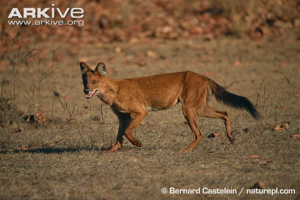



### example 13601 ###

      label_name prediction_label_name
13601     coyote              grey fox


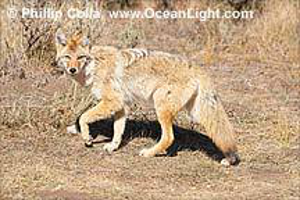



### example 13602 ###

      label_name prediction_label_name
13602     coyote              grey fox


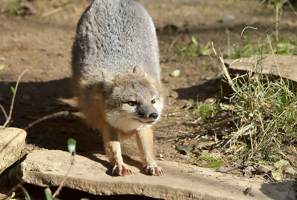




###############
   cluster 1 
###############
            
accuracy: 0.09 (4/47)

prediction_label_name counts: {'tabby': 17, 'tiger': 12, 'Egyptian cat': 6, 'tiger cat': 4, 'lynx': 3}
label_name counts: {'tiger cat': 47}


### example 14100 ###

      label_name prediction_label_name
14100  tiger cat                 tabby


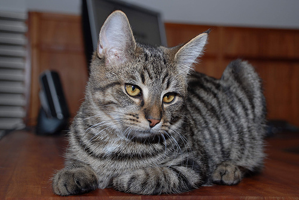



### example 14101 ###

      label_name prediction_label_name
14101  tiger cat                 tiger


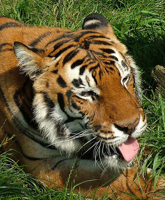



### example 14102 ###

      label_name prediction_label_name
14102  tiger cat                 tabby


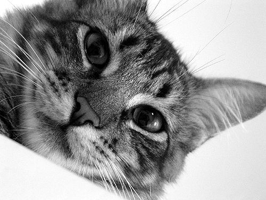




###############
   cluster 2 
###############
            
accuracy: 0.04 (2/47)

prediction_label_name counts: {'wardrobe': 19, 'file': 9, 'sliding door': 3, 'chiffonier': 2, 'medicine chest': 2}
label_name counts: {'chiffonier': 40, 'medicine chest': 2}


### example 24650 ###

       label_name prediction_label_name
24650  chiffonier              wardrobe


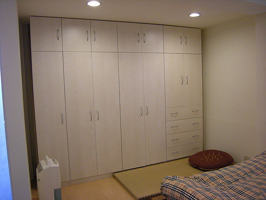



### example 24651 ###

       label_name prediction_label_name
24651  chiffonier              wardrobe


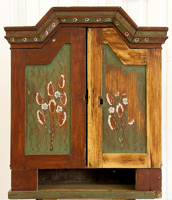



### example 24652 ###

       label_name prediction_label_name
24652  chiffonier              wardrobe


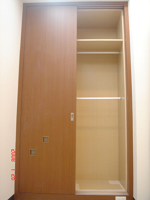




###############
   cluster 3 
###############
            
accuracy: 0.08 (4/48)

prediction_label_name counts: {'notebook': 32, 'laptop': 4, 'screen': 3}
label_name counts: {'laptop': 48}


### example 31000 ###

      label_name prediction_label_name
31000     laptop              notebook


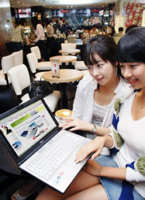



### example 31001 ###

      label_name prediction_label_name
31001     laptop                 mouse


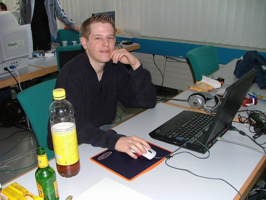



### example 31002 ###

      label_name prediction_label_name
31002     laptop              notebook


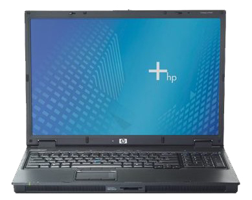




###############
   cluster 4 
###############
            
accuracy: 0.06 (3/49)

prediction_label_name counts: {'sunglasses': 16, 'sunglass': 3, 'seat belt': 2}
label_name counts: {'sunglass': 49}


### example 41800 ###

      label_name prediction_label_name
41800   sunglass                paddle


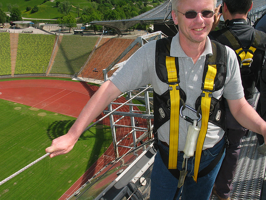



### example 41801 ###

      label_name prediction_label_name
41801   sunglass            barbershop


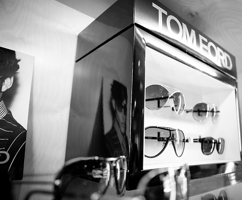



### example 41802 ###

      label_name prediction_label_name
41802   sunglass            sunglasses


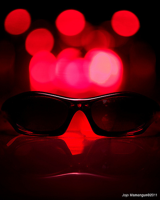




###############
   cluster 5 
###############
            
accuracy: 0.09 (3/34)

prediction_label_name counts: {'agaric': 18, 'bolete': 8, 'mushroom': 3, 'stinkhorn': 2}
label_name counts: {'mushroom': 34}


### example 47350 ###

      label_name prediction_label_name
47350   mushroom                bolete


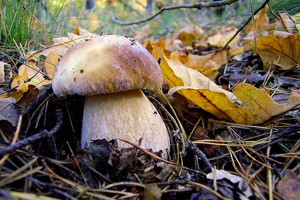



### example 47351 ###

      label_name prediction_label_name
47351   mushroom                   wok


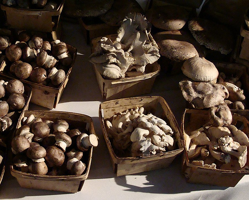



### example 47352 ###

      label_name prediction_label_name
47352   mushroom          coral fungus


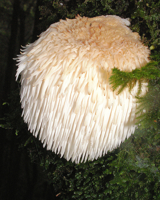

In [100]:
print(f"### total number of clusters satisfying the rule: {len(rule_clusters)}")
for displayer in rule_displayers:
    displayer(rule_clusters, data)

we see that we are able to get meaningful results, uncovering insights that standard clustering did not uncover.  some of the clusters:
- "coyote" is often mis-predicted to be "grey fox" or "dhole", which are also kinds of dogs.
- "tiger cat" is often mis-predicted to be "tabby" and "tiger", presumably because the latter are cats that resemble the former.
- "chiffonier" is often mis-predicted to be "wardrobe" and "file".  this makes sense, as all are different kinds of furniture that could be confused for each other.